In [12]:
# A Code to fit sedona models to supernova light curves
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from light_curve import create_lc

%config InlineBackend.figure_format = 'retina'
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# Object Details

#=============================================================================
# Details of the object under study
# =============================================================================

Object = 'SN2011aa'       
Redshift = 0.013               # From https://www.wis-tns.org/object/2020sck
EB_V_Gal = 0.065                # Only considering the Galaxy component  https://ned.ipac.caltech.edu/
EB_V_err_Gal = 0.003             # Schlafly & Finkbeiner 2011.
EB_V_Host = 0.00                # No Na-I D lines in HCT spectra observed at the redshift of the host galaxy.
EB_V_err_Host = 0.00
JD_offset = 2459000
epoch = 2400000.5
RA = '07:36:42.63'            # https://www.wis-tns.org/object/2011aa
DEC = '+74:26:34.80'
Rv_MW = 3.1                    # The value of total-to-selective absorption
Rv_HG = 3.1
B_maximum = 611.65        # Calculated from spline, MLCS2k2 and SNooPy(E(B-V) model) 
DM = 33.75                    # http://leda.univ-lyon1.fr/ledacat.cgi?o=2MASX%20J01103497%2B0206508%20
DM_err = 0.27                  # 
dm15 = 0.59                    # Calculated from GP-fit
dm15_err = 0.01
z = 0.013

In [14]:
# Sedona Model Light Curve
sedona_lc_1 = '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/Model1_lc.out'
sedona_lc_2 = '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/Model2_lc.out'
sedona_lc_3 = '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/Model3_lc.out'
sedona_lc_4 = '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/Model4_lc.out'
sedona_lc_6 = '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/Model6_lc.out'


# SN 2011aa bolometry light curve
bolometry_lc =  '/Users/anirbandutta/Documents/SN2011aa_Work/SN2011_Anirban/Bolometry/bolometry_total.dat'

# Magnitude File for SN 2011aa
optical_mag = '/Users/anirbandutta/Documents/SN2011aa_Work/SN2011_Anirban/Photometry/2011aa_ubvri_mag'

# A filter file containing all the required information on bandpasses
FILTER_directory = '/Users/anirbandutta/Dropbox/astromatic/'            # Filter information 
FILTER_data = FILTER_directory+'FILTERS.dat'

save_results = '/Users/anirbandutta/Dropbox/pysn/SN2011aa/SEDONA_Models/'


In [4]:
# Read the filter file containing data on filters 

filter_df = pd.read_csv(FILTER_data, sep = '\s+')
filter_df = filter_df.replace('INDEF', np.nan).set_index(['FILTER', 'Marker', 'Color']).astype('float64')
filter_df = filter_df.reset_index().set_index('FILTER')
list_filters = filter_df.index.tolist()

In [6]:
# =============================================================================#
# Calculated in extinction_v1.py script using Fitzpatrick 1999 
# =============================================================================#
# This way gives us freedom to use different extinction law for Host

R_lambda_MW = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45}

R_lambda_HG = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45}

# =============================================================================#

# =============================================================================#
# Calculate ZeroPoint
# =============================================================================#

Zeropoint = {'U': 3.97e-9, 'B': 6.13e-9, 'V': 3.63e-9, 'R': 2.17e-9, 'I': 1.13e-9,
            'uvw2': 5.36e-9, 'uvm2': 4.68e-9, 'uvw1': 4.15e-9, 'uvu': 3.63e-9, 'uvb': 6.48e-9,
            'uvv': 3.73e-9}



In [24]:
def calculate_dm(dist, dist_err):
    
    '''
    Remarks:
    dist: Distance
    dist_err: error in the measured distance
    Returns the value of Distance Modulus and Distance Modulus Error.

    The distance modulus is a measure of the distance to an object in magnitude units. 
    An object with a distance modulus of 'zero' is exactly 10 parsecs away. 
    If an object has a negative distance modulus( D.M.), that means 
    it is closer than 10 parsecs and if it has a positive D.M.
    that means it is farther than 10 parsec.

    m-M = 5*log(D)-5
    Here m-M is called the Distance Modulus. 
    
    m : apparent magnitude of the object
    M : absolute magnitude of the object
    D : Distance to the object in parsec

    '''
    
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    
    return [distmod, distmod_err]

# -------------------------------------------------------------------------------- #

def calculate_dist(dist_mod, dist_modd_err):
    
    d = (10**((dist_mod+5)/5))/10**6
    d_err = (2.303 * d * dist_modd_err)/5
    
    return d, d_err

# -------------------------------------------------------------------------------- #

def calculate_zp(band):
    
    zp = -2.5*np.log10(Zeropoint[band]) - 21.100
    zp = round(zp, 3)
    
    return zp

def cal_flux(mag, err, band, name, ext_err=False):
    
    mag = float(mag)
    err = float(err)
    zp = calculate_zp(band)
    
    if name != '':
        dist = pd.to_numeric(SNdata_df.loc[name, 'Distance'])
        dist_err = pd.to_numeric(SNdata_df.loc[name, 'Distance_err'])
        ebv = pd.to_numeric(SNdata_df.loc[name, 'EB_V'])
        ebv_err = pd.to_numeric(SNdata_df.loc[name, 'EB_V_err'])
        
    else:
        dist, dist_err = calculate_dist(DM, DM_err)
        ebv_MW = EB_V_Gal
        ebv_HG = EB_V_Host
        
        if ext_err:
            ebv_err_MW = EB_V_err_Gal
            ebv_err_HG = EB_V_err_Host
        else:
            ebv_err_MW = 0.0
            ebv_err_HG = 0.0
        
    ##---------- Distance Modulus ----------##
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    ##--------------------------------------##
    
    ##---------- Absolute Magnitude ----------##
    absmag = mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) - distmod
    absmag_err = (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
                  (R_lambda_HG[band] * ebv_err_HG)**2 + distmod_err**2)**0.5
    ##--------------------------------------##
    
    ##---------- Flux ----------##
    flux = 10**(-0.4 * (mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) 
                        + zp + 21.10))
    flux_err = 2.303 * flux * (0.4 * (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
                  (R_lambda_HG[band] * ebv_err_HG)**2))
    ##--------------------------------------##
    
    ##---------- Luminosity ----------##
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*dist**2
    luminosity_err = (8*np.pi*flux) * (dist) * (dist_err) * (3.086e24)**2
    ##--------------------------------------## 
    
    return float(absmag), float(absmag_err), float(flux), float(flux_err), \
            float(luminosity), float(luminosity_err)


def sn_abs_df(sn_df, name):
    
    '''
    Info: 
    data: the SN-dataframe under study.
    B_max: maximum magnitude in B-band.
    
    Returns: the absolute magnitude dataframe along with separate dataframes for 
    total, B, V, R, I, U
    Remarks: Future version will include itertuples.
    
    '''
    
    #sn_df = pd.read_csv(data, sep = '\s+', engine = 'python')
    #sn_df['Date'] = sn_df['JD'].apply(lambda x: jd_2_gcal(x))
    sn_df['FILTER'] = sn_df['FILTER'].apply(lambda x: x if 'UV' not in x else x.lower())

    for index, band in sn_df['FILTER'].items():
        if name != '':
            magflux = cal_flux(mag = sn_df.loc[index, 'MAG'], 
                           err = sn_df.loc[index, 'MERR'], band = band, name = name)
        else:
            magflux = cal_flux(mag = sn_df.loc[index, 'MAG'], 
                           err = sn_df.loc[index, 'MERR'], band = band, name = '')
        sn_df.loc[index, 'AbsMag'] = magflux[0]
        sn_df.loc[index, 'AbsErr'] = magflux[1]
        sn_df.loc[index, 'Flux'] = magflux[2]
        sn_df.loc[index, 'FluxErr'] = magflux[3]
        sn_df.loc[index, 'Lum'] = magflux[4]
        sn_df.loc[index, 'Lum_Err'] = magflux[5]
    
    return sn_df

def plot_params(ax, ml_x, mil_x, ml_y, mil_y, invert=False):
    
    '''
    Remarks: Plotting parameters
    ax: axis object
    ml_x: major locator 'x'
    mil_x: minor locator 'x'
    ml_y: major locator 'y'
    mil_y: minor locator 'y'
    invert: Bool for the y-axis to be inverted 
    
    '''
    
    if invert:
        ax.invert_yaxis()
        
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 2.0, labelsize = 12)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 1.2, labelsize = 12)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))

In [17]:
## Model 1

columns = ['Time', 'Lbol', 'Mbol', 'U', 'B', 'V', 'Cousins_R', 'Cousins_I']
sedona_lc1_df = pd.read_csv(sedona_lc_1, names=columns, 
                             sep='\s+', engine='python', skiprows=2, comment='#')
# Blanton et al. 2007

sedona_lc1_df['U_Vega'] = sedona_lc1_df['U'] - 0.79
sedona_lc1_df['B_Vega'] = sedona_lc1_df['B'] + 0.09
sedona_lc1_df['V_Vega'] = sedona_lc1_df['V'] - 0.02
sedona_lc1_df['R_Vega'] = sedona_lc1_df['Cousins_R'] - 0.21
sedona_lc1_df['I_Vega'] = sedona_lc1_df['Cousins_I'] - 0.45

#sedona_lc1_df['U_Vega'] = sedona_lc1_df['U']
#sedona_lc1_df['B_Vega'] = sedona_lc1_df['B']
#sedona_lc1_df['V_Vega'] = sedona_lc1_df['V']
#sedona_lc1_df['R_Vega'] = sedona_lc1_df['Cousins_R']
#sedona_lc1_df['I_Vega'] = sedona_lc1_df['Cousins_I']

sedona_lc1_df = sedona_lc1_df[(sedona_lc1_df['Time'] > 2.0) & (sedona_lc1_df['Time'] < 60.0)]

In [9]:
## Model 2

columns = ['Time', 'Lbol', 'Mbol', 'U', 'B', 'V', 'Cousins_R', 'Cousins_I']
sedona_lc2_df = pd.read_csv(sedona_lc_2, names=columns, 
                             sep='\s+', engine='python', skiprows=2, comment='#')
# Blanton et al. 2007

sedona_lc2_df['U_Vega'] = sedona_lc2_df['U'] - 0.79
sedona_lc2_df['B_Vega'] = sedona_lc2_df['B'] + 0.09
sedona_lc2_df['V_Vega'] = sedona_lc2_df['V'] - 0.02
sedona_lc2_df['R_Vega'] = sedona_lc2_df['Cousins_R'] - 0.21
sedona_lc2_df['I_Vega'] = sedona_lc2_df['Cousins_I'] - 0.45

sedona_lc2_df = sedona_lc2_df[(sedona_lc2_df['Time'] > 2.0) & (sedona_lc2_df['Time'] < 60.0)]

In [10]:
columns = ['Time', 'Lbol', 'Mbol', 'U', 'B', 'V', 'Cousins_R', 'Cousins_I']
sedona_lc3_df = pd.read_csv(sedona_lc_3, names=columns, 
                             sep='\s+', engine='python', skiprows=2, comment='#')
# Blanton et al. 2007

sedona_lc3_df['U_Vega'] = sedona_lc3_df['U'] - 0.79
sedona_lc3_df['B_Vega'] = sedona_lc3_df['B'] + 0.09
sedona_lc3_df['V_Vega'] = sedona_lc3_df['V'] - 0.02
sedona_lc3_df['R_Vega'] = sedona_lc3_df['Cousins_R'] - 0.21
sedona_lc3_df['I_Vega'] = sedona_lc3_df['Cousins_I'] - 0.45

sedona_lc3_df = sedona_lc3_df[(sedona_lc3_df['Time'] > 2.0) & (sedona_lc3_df['Time'] < 60.0)]

In [11]:
columns = ['Time', 'Lbol', 'Mbol', 'U', 'B', 'V', 'Cousins_R', 'Cousins_I']
sedona_lc4_df = pd.read_csv(sedona_lc_4, names=columns, 
                             sep='\s+', engine='python', skiprows=2, comment='#')
# Blanton et al. 2007

sedona_lc4_df['U_Vega'] = sedona_lc4_df['U'] - 0.79
sedona_lc4_df['B_Vega'] = sedona_lc4_df['B'] + 0.09
sedona_lc4_df['V_Vega'] = sedona_lc4_df['V'] - 0.02
sedona_lc4_df['R_Vega'] = sedona_lc4_df['Cousins_R'] - 0.21
sedona_lc4_df['I_Vega'] = sedona_lc4_df['Cousins_I'] - 0.45

sedona_lc4_df = sedona_lc4_df[(sedona_lc4_df['Time'] > 2.0) & (sedona_lc4_df['Time'] < 60.0)]

In [31]:
lc = create_lc(optical_mag)
sn_df = lc.column_to_row(offset = 2455000.0)
sn_df = sn_df[sn_df['MAG'] != 99.99]

In [32]:
flux_df_UBVRI = sn_abs_df(sn_df, name='')
flux_df_UBVRI['Texp'] = (flux_df_UBVRI['JD'] - 2455592.88)/ (1 + z)

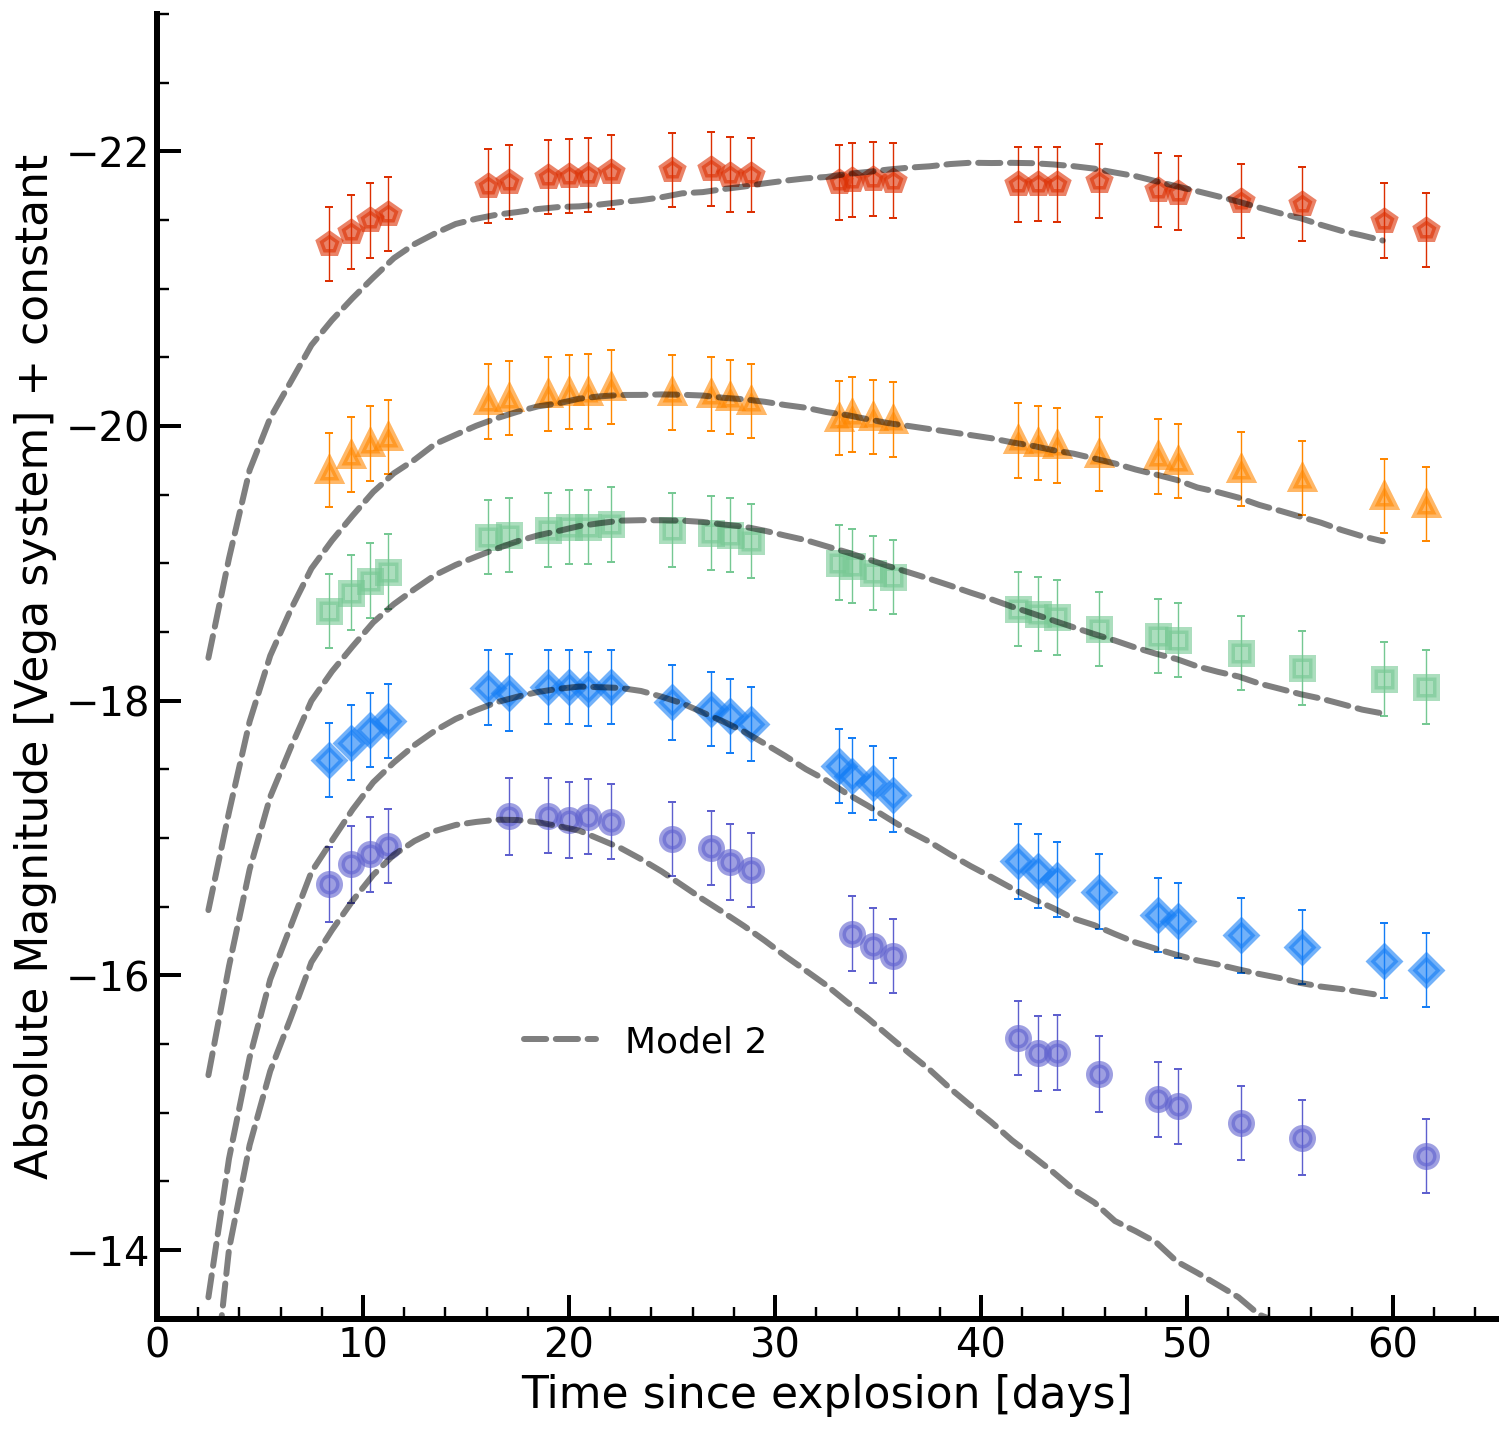

In [33]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)


plot_params(ax, ml_x = 10, mil_x = 2, ml_y = 2, mil_y = 0.5, invert=True)
legend_properties = {'size':18, 'weight':'book'}
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.linewidth'] = 3

#==========================================================================================#
offset = [+1.2, -2.7, -1.0, +2.7, +0.0]
str_offset = ['+1.2', '-2.7', '-1.0 ', '+2.7', ' ']
color = ['#005F73', '#57CC99']
i = 0
line1 =[]
for band, band_df in flux_df_UBVRI.groupby('FILTER'):
    line1 += ax.plot(band_df['Texp'], band_df['AbsMag']+offset[i], mfc = filter_df.loc[band, 'Color'],
                    mec = filter_df.loc[band, 'Color'], markeredgewidth=3.5, 
                    marker = filter_df.loc[band, 'Marker'],  markersize = 10,
                    alpha = 0.6, ls = ' ')
                     
    ax.errorbar(band_df['Texp'], band_df['AbsMag']+offset[i], yerr = band_df['AbsErr'], fmt = '',
                c = filter_df.loc[band, 'Color'], ls = '', lw = 0.7, capsize=2, capthick=1,
                )
    line1.append(line1)
    
    i = i+1
#==========================================================================================#    


ax.plot(sedona_lc2_df['Time'], sedona_lc2_df['B_Vega']+1.2, color='black', linewidth=3.0, ls='--', alpha=0.5, label='Model 2', dash_capstyle='round')
ax.plot(sedona_lc2_df['Time'], sedona_lc2_df['I_Vega']-2.7, color='black', linewidth=3.0, ls='--', alpha=0.5, dash_capstyle='round')
ax.plot(sedona_lc2_df['Time'], sedona_lc2_df['R_Vega']-1.0, color='black', linewidth=3.0, ls='--', alpha=0.5, dash_capstyle='round')
ax.plot(sedona_lc2_df['Time'], sedona_lc2_df['U_Vega']+2.7, color='black', linewidth=3.0, ls='--', alpha=0.5, dash_capstyle='round')
ax.plot(sedona_lc2_df['Time'], sedona_lc2_df['V_Vega']+0.0, color='black', linewidth=3.0, ls='--', alpha=0.5, dash_capstyle='round')    
#==========================================================================================# 
    
    
ax.set_xlabel('Time since explosion [days]', fontsize = 22)
ax.set_ylabel('Absolute Magnitude [Vega system] + constant', fontsize = 22)


for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    #tick.label1.set_fontweight('bold')
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    #tick.label1.set_fontweight('bold')
ax.set_xlim(0, 65)    
ax.set_ylim(-13.5, -23)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(frameon= False, fancybox = False, shadow = False, facecolor = 'white', 
        prop = legend_properties, framealpha=0.3,
                    bbox_to_anchor = (0.25, 0.25))

In [34]:
color_df = lc.color(sn_df, 'B-V', ebv_Gal=EB_V_Gal, ebv_Gerr=EB_V_err_Gal)

In [36]:
color_df['Texp'] = color_df['JD'].apply(lambda x: x - 2455592.88)

<ErrorbarContainer object of 3 artists>

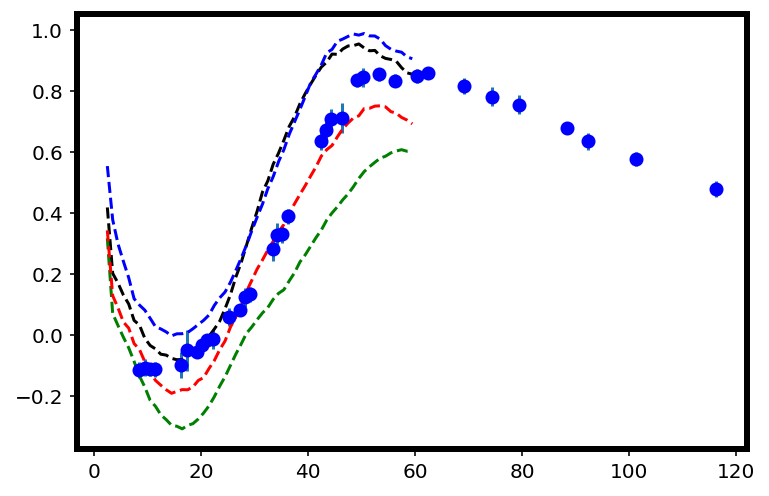

In [47]:
plt.plot(sedona_lc2_df['Time'], sedona_lc2_df['B_Vega']-sedona_lc2_df['V_Vega'], 'k--')
plt.plot(sedona_lc1_df['Time'], sedona_lc1_df['B_Vega']-sedona_lc1_df['V_Vega'], 'b--')
plt.plot(sedona_lc3_df['Time'], sedona_lc3_df['B_Vega']-sedona_lc3_df['V_Vega'], 'g--')
plt.plot(sedona_lc4_df['Time'], sedona_lc4_df['B_Vega']-sedona_lc4_df['V_Vega'], 'r--')



plt.plot(color_df['Texp'], color_df['B-V'], 'bo')
plt.errorbar(color_df['Texp'], color_df['B-V'], yerr=color_df['B-VErr'], fmt='', ls='')

In [48]:
color_df2 = lc.color(sn_df, 'V-R', ebv_Gal=EB_V_Gal, ebv_Gerr=EB_V_err_Gal)

In [49]:
color_df2['Texp'] = color_df2['JD'].apply(lambda x: x - 2455592.88)

<ErrorbarContainer object of 3 artists>

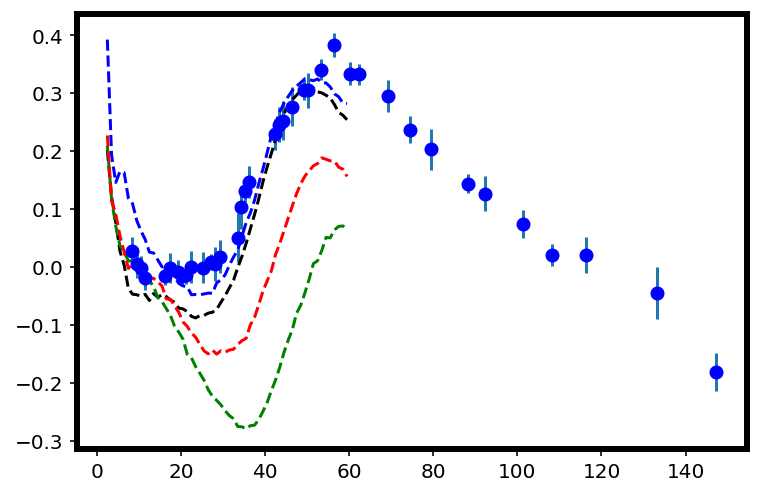

In [52]:
plt.plot(sedona_lc2_df['Time'], sedona_lc2_df['V_Vega']-sedona_lc2_df['R_Vega'], 'k--')
plt.plot(sedona_lc1_df['Time'], sedona_lc1_df['V_Vega']-sedona_lc1_df['R_Vega'], 'b--')
plt.plot(sedona_lc3_df['Time'], sedona_lc3_df['V_Vega']-sedona_lc3_df['R_Vega'], 'g--')
plt.plot(sedona_lc4_df['Time'], sedona_lc4_df['V_Vega']-sedona_lc4_df['R_Vega'], 'r--')



plt.plot(color_df2['Texp'], color_df2['V-R'], 'bo')
plt.errorbar(color_df2['Texp'], color_df2['V-R'], yerr=color_df2['V-RErr'], fmt='', ls='')

In [53]:
color_df3 = lc.color(sn_df, 'U-B', ebv_Gal=EB_V_Gal, ebv_Gerr=EB_V_err_Gal)

In [54]:
color_df3['Texp'] = color_df3['JD'].apply(lambda x: x - 2455592.88)

<ErrorbarContainer object of 3 artists>

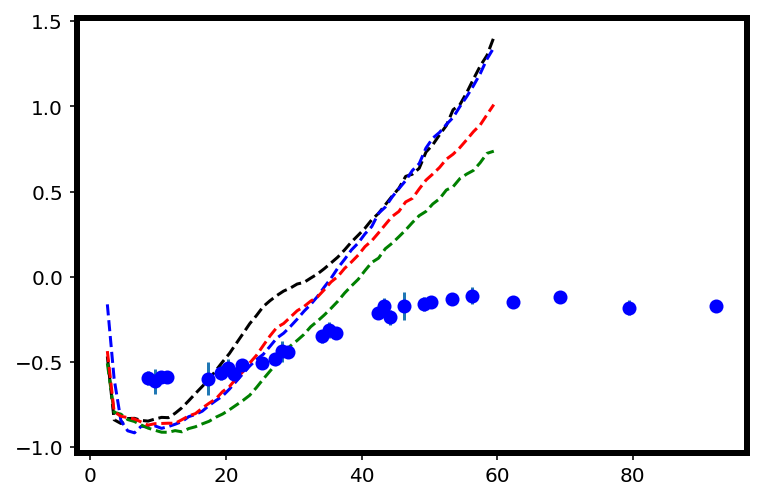

In [55]:
plt.plot(sedona_lc2_df['Time'], sedona_lc2_df['U_Vega']-sedona_lc2_df['B_Vega'], 'k--')
plt.plot(sedona_lc1_df['Time'], sedona_lc1_df['U_Vega']-sedona_lc1_df['B_Vega'], 'b--')
plt.plot(sedona_lc3_df['Time'], sedona_lc3_df['U_Vega']-sedona_lc3_df['B_Vega'], 'g--')
plt.plot(sedona_lc4_df['Time'], sedona_lc4_df['U_Vega']-sedona_lc4_df['B_Vega'], 'r--')



plt.plot(color_df3['Texp'], color_df3['U-B'], 'bo')
plt.errorbar(color_df3['Texp'], color_df3['U-B'], yerr=color_df3['U-BErr'], fmt='', ls='')

In [56]:
sedona_lc1_df

,Time,Lbol,Mbol,U,B,V,Cousins_R,Cousins_I,U_Vega,B_Vega,V_Vega,R_Vega,I_Vega
2,2.5,8.179535e+40,-13.58440,-12.39842,-13.11630,-13.55929,-13.76197,-13.73811,-13.18842,-13.02630,-13.57929,-13.97197,-14.18811
3,3.5,3.527164e+41,-15.17114,-14.58497,-14.86626,-15.13300,-15.13712,-15.02505,-15.37497,-14.77626,-15.15300,-15.34712,-15.47505
4,4.5,9.333324e+41,-16.22767,-15.89277,-15.92848,-16.11572,-16.07181,-15.95611,-16.68277,-15.83848,-16.13572,-16.28181,-16.40611
5,5.5,1.811185e+42,-16.94748,-16.63095,-16.60618,-16.73649,-16.71154,-16.63606,-17.42095,-16.51618,-16.75649,-16.92154,-17.08606
6,6.5,2.903187e+42,-17.45976,-17.15266,-17.11599,-17.19214,-17.16522,-17.02725,-17.94266,-17.02599,-17.21214,-17.37522,-17.47725
7,7.5,4.319232e+42,-17.89109,-17.59345,-17.59555,-17.60331,-17.53248,-17.32120,-18.38345,-17.50555,-17.62331,-17.74248,-17.77120
8,8.5,5.478580e+42,-18.14924,-17.88166,-17.87882,-17.86569,-17.78516,-17.53451,-18.67166,-17.78882,-17.88569,-17.99516,-17.98451
9,9.5,6.743735e+42,-18.37483,-18.12934,-18.13371,-18.10395,-17.99432,-17.71124,-18.91934,-18.04371,-18.12395,-18.20432,-18.16124
10,10.5,8.089081e+42,-18.57232,-18.36974,-18.35940,-18.30295,-18.17547,-17.85998,-19.15974,-18.26940,-18.32295,-18.38547,-18.30998
11,11.5,9.294641e+42,-18.72316,-18.54380,-18.54397,-18.45969,-18.31755,-18.00693,-19.33380,-18.45397,-18.47969,-18.52755,-18.45693


In [57]:
sedona_lc2_df

,Time,Lbol,Mbol,U,B,V,Cousins_R,Cousins_I,U_Vega,B_Vega,V_Vega,R_Vega,I_Vega
2,2.5,3.848458e+41,-15.26579,-14.53340,-14.94549,-15.25267,-15.26474,-15.16172,-15.32340,-14.85549,-15.27267,-15.47474,-15.61172
3,3.5,9.477822e+41,-16.24435,-15.91486,-15.95509,-16.04612,-15.97811,-15.88664,-16.70486,-15.86509,-16.06612,-16.18811,-16.33664
4,4.5,1.874717e+42,-16.98491,-16.67277,-16.69105,-16.74980,-16.63752,-16.52824,-17.46277,-16.60105,-16.76980,-16.84752,-16.97824
5,5.5,2.989538e+42,-17.49159,-17.21227,-17.25942,-17.27913,-17.11685,-16.90819,-18.00227,-17.16942,-17.29913,-17.32685,-17.35819
6,6.5,4.112265e+42,-17.83778,-17.60091,-17.64951,-17.63967,-17.45332,-17.17219,-18.39091,-17.55951,-17.65967,-17.66332,-17.62219
7,7.5,5.666894e+42,-18.18594,-18.00591,-18.04224,-17.97874,-17.75197,-17.43857,-18.79591,-17.95224,-17.99874,-17.96197,-17.88857
8,8.5,6.775859e+42,-18.37999,-18.23953,-18.27179,-18.19302,-17.95638,-17.62104,-19.02953,-18.18179,-18.21302,-18.16638,-18.07104
9,9.5,8.088760e+42,-18.57228,-18.45322,-18.49732,-18.37528,-18.13764,-17.78120,-19.24322,-18.40732,-18.39528,-18.34764,-18.23120
10,10.5,9.442174e+42,-18.74026,-18.64118,-18.69527,-18.54950,-18.30936,-17.93019,-19.43118,-18.60527,-18.56950,-18.51936,-18.38019
11,11.5,1.058949e+43,-18.86476,-18.78702,-18.83935,-18.68220,-18.44530,-18.07188,-19.57702,-18.74935,-18.70220,-18.65530,-18.52188


In [58]:
sedona_lc3_df

,Time,Lbol,Mbol,U,B,V,Cousins_R,Cousins_I,U_Vega,B_Vega,V_Vega,R_Vega,I_Vega
2,2.5,4.022361e+41,-15.31378,-14.68026,-15.05176,-15.25756,-15.27715,-15.20183,-15.47026,-14.96176,-15.27756,-15.48715,-15.65183
3,3.5,9.999858e+41,-16.30256,-16.01866,-16.10288,-16.06189,-15.98935,-15.80219,-16.80866,-16.01288,-16.08189,-16.19935,-16.25219
4,4.5,1.950015e+42,-17.02767,-16.75207,-16.82494,-16.74432,-16.62538,-16.40891,-17.54207,-16.73494,-16.76432,-16.83538,-16.85891
5,5.5,3.082138e+42,-17.52471,-17.29506,-17.33641,-17.21759,-17.06494,-16.76415,-18.08506,-17.24641,-17.23759,-17.27494,-17.21415
6,6.5,4.212710e+42,-17.86398,-17.67240,-17.70218,-17.54840,-17.38526,-17.05637,-18.46240,-17.61218,-17.56840,-17.59526,-17.50637
7,7.5,5.702020e+42,-18.19265,-18.04541,-18.05482,-17.85667,-17.67718,-17.29119,-18.83541,-17.96482,-17.87667,-17.88718,-17.74119
8,8.5,6.774745e+42,-18.37981,-18.27660,-18.26772,-18.02191,-17.84304,-17.45874,-19.06660,-18.17772,-18.04191,-18.05304,-17.90874
9,9.5,8.009392e+42,-18.56157,-18.48875,-18.46755,-18.18556,-17.99867,-17.59268,-19.27875,-18.37755,-18.20556,-18.20867,-18.04268
10,10.5,9.294148e+42,-18.72310,-18.68768,-18.65472,-18.32900,-18.13702,-17.69621,-19.47768,-18.56472,-18.34900,-18.34702,-18.14621
11,11.5,1.037809e+43,-18.84287,-18.82944,-18.79594,-18.45045,-18.24620,-17.78534,-19.61944,-18.70594,-18.47045,-18.45620,-18.23534


In [59]:
sedona_lc4_df

,Time,Lbol,Mbol,U,B,V,Cousins_R,Cousins_I,U_Vega,B_Vega,V_Vega,R_Vega,I_Vega
2,2.5,3.948121e+41,-15.29355,-14.57507,-15.01843,-15.25041,-15.28768,-15.17964,-15.36507,-14.92843,-15.27041,-15.49768,-15.62964
3,3.5,9.874475e+41,-16.28886,-15.98138,-16.06870,-16.08634,-16.01186,-15.89091,-16.77138,-15.97870,-16.10634,-16.22186,-16.34091
4,4.5,1.942668e+42,-17.02357,-16.74125,-16.80189,-16.77910,-16.68047,-16.48003,-17.53125,-16.71189,-16.79910,-16.89047,-16.93003
5,5.5,3.060538e+42,-17.51707,-17.27093,-17.32378,-17.25506,-17.11946,-16.84424,-18.06093,-17.23378,-17.27506,-17.32946,-17.29424
6,6.5,4.214791e+42,-17.86452,-17.66086,-17.70557,-17.61660,-17.45310,-17.11627,-18.45086,-17.61557,-17.63660,-17.66310,-17.56627
7,7.5,5.726471e+42,-18.19729,-18.04105,-18.06809,-17.92850,-17.73637,-17.37611,-18.83105,-17.97809,-17.94850,-17.94637,-17.82611
8,8.5,6.831592e+42,-18.38888,-18.27397,-18.28254,-18.12382,-17.93860,-17.53543,-19.06397,-18.19254,-18.14382,-18.14860,-17.98543
9,9.5,8.104708e+42,-18.57442,-18.47877,-18.49582,-18.29689,-18.10283,-17.70242,-19.26877,-18.40582,-18.31689,-18.31283,-18.15242
10,10.5,9.393219e+42,-18.73461,-18.66427,-18.68267,-18.45066,-18.25668,-17.84250,-19.45427,-18.59267,-18.47066,-18.46668,-18.29250
11,11.5,1.055657e+43,-18.86138,-18.82003,-18.83986,-18.57933,-18.37623,-17.93745,-19.61003,-18.74986,-18.59933,-18.58623,-18.38745
